Version de Python utilisée : <b>Python 3.7.11</b>

## Import des modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tqdm import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
print('Imports terminés')

Imports terminés


## 1. Statistiques descriptives

### 1. Décrivez le jeu de données

In [ ]:
# Lecture des données
data = pd.read_csv('data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20000 non-null  int64  
 1   index       20000 non-null  int64  
 2   date        19909 non-null  object 
 3   cheveux     19897 non-null  object 
 4   age         19909 non-null  float64
 5   exp         19904 non-null  float64
 6   salaire     19905 non-null  float64
 7   sexe        19900 non-null  object 
 8   diplome     19890 non-null  object 
 9   specialite  19907 non-null  object 
 10  note        19886 non-null  float64
 11  dispo       19894 non-null  object 
 12  embauche    20000 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 2.0+ MB


In [ ]:
data.shape

(20000, 13)

In [ ]:
data.head()

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


Dans le cadre de notre analyse, on pourra se passer des colonnes 'index' et 'date' qui ne seront a priori pas pertinents pour notre prédicition.

On peut maintenant essayer de savoir combien de valeurs manquantes comporte notre jeu de données.

In [ ]:
# Compter les valeurs manquantes
data.isna().sum()

Unnamed: 0      0
index           0
date           91
cheveux       103
age            91
exp            96
salaire        95
sexe          100
diplome       110
specialite     93
note          114
dispo         106
embauche        0
dtype: int64

In [ ]:
# On s'interesse aux modalités présentes au sein des différentes classes
for col in data.select_dtypes(include='object').columns:
    nb = data[col].nunique()
    if nb > 1:
        print(f'La colonne {col} dispose de {nb} modalités')

La colonne date dispose de 1826 modalités
La colonne cheveux dispose de 4 modalités
La colonne sexe dispose de 2 modalités
La colonne diplome dispose de 4 modalités
La colonne specialite dispose de 4 modalités
La colonne dispo dispose de 2 modalités


In [ ]:
data.describe()

,Unnamed: 0,index,age,exp,salaire,note,embauche
count,20000.000000,20000.000000,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,9999.500000,9999.500000,35.004521,9.500352,34974.343934,75.168762,0.114600
std,5773.647028,5773.647028,9.609169,3.012109,5003.099616,17.095926,0.318547
min,0.000000,0.000000,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,4999.750000,4999.750000,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,9999.500000,9999.500000,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,14999.250000,14999.250000,41.000000,12.000000,38358.000000,86.617500,0.000000
max,19999.000000,19999.000000,74.000000,23.000000,53977.000000,143.220000,1.000000


Ici, on va filtrer les valeurs aberrantes qu'on peut observer au niveau de l'âge et de l'expérience.

<AxesSubplot:>

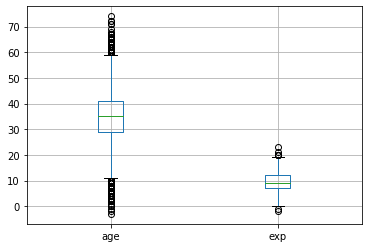

In [ ]:
data.boxplot(column=['age','exp'])

In [ ]:
#Avant le filtre
data.shape

(20000, 13)

In [ ]:
data = data[ (data['age'] > 10) & (data['age'] < 60) & (data['exp'] > 0) & (data['exp'] < 19) ]
data.shape # On perd à peu près 600 lignes

(19554, 13)

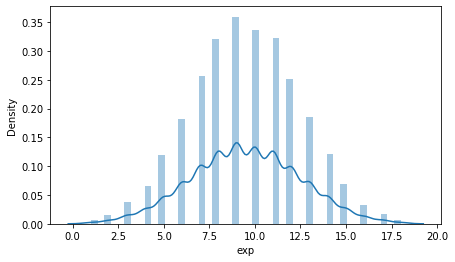

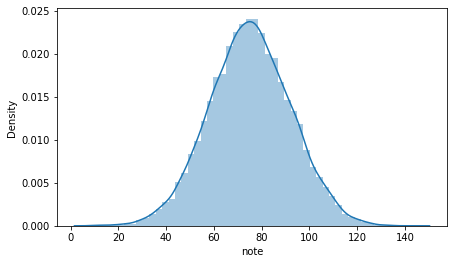

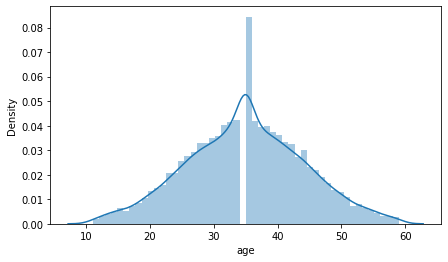

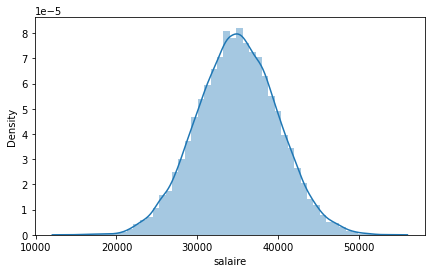

In [ ]:
x = ['exp','note','age','salaire']
    
for i in x:
    plt.figure(figsize=(7,4))
    sns.distplot(data[i], hist=True, kde=True)
    plt.show()

### Distribution de la cible (Target)


<AxesSubplot:xlabel='embauche', ylabel='count'>

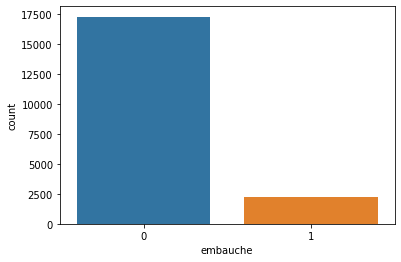

In [ ]:
sns.countplot(data['embauche'])

In [ ]:
data['embauche'].value_counts(normalize=True)

0    0.885394
1    0.114606
Name: embauche, dtype: float64

On remarque qu'on a, pour les 20000 enregistrements:
<ul>
<li>89% de recalés
<li>11% de personnes embauchées
</ul>

In [ ]:
data.head()

,Unnamed: 0,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
4,4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0
5,5,5,2014-02-12,chatain,37.0,8.0,38558.0,M,master,geologie,63.46,non,1


Comme pré-traitement, on va:
<ul>
<li> Créer des classes d'âge et de salaire pour améliorer le futur apprentissage
<li> Traiter les valeurs manquantes dans les champs en imputant les <b>medianes</b> aux variables continues et les <b>modes</b> aux variables catégorielles
</ul>

### Création des classes d'âge et salaire

In [ ]:
data['salaire'] = pd.cut(x=data['salaire'], bins=[0,30000,35000,40000,70000])
data['age'] = pd.cut(x=data['age'], bins=[0,30,40,50,70])

### Traitement des valeurs manquantes

In [ ]:
# Variable continue --> Moyenne / Mediane
data['exp'] = data['exp'].fillna(data['exp'].median())
data['note'] = data['note'].fillna(data['note'].median())

#Variable categorielle --> Mode
data['diplome'] = data['diplome'].fillna(data['diplome'].mode().iloc[0])
data['sexe'] = data['sexe'].fillna(data['sexe'].mode().iloc[0])
data['cheveux'] = data['cheveux'].fillna(data['cheveux'].mode().iloc[0])
data['specialite'] = data['specialite'].fillna(data['specialite'].mode().iloc[0])
data['dispo'] = data['dispo'].fillna(data['dispo'].mode().iloc[0])
data['age'] = data['age'].fillna(data['age'].mode().iloc[0])
data['salaire'] = data['salaire'].fillna(data['salaire'].mode().iloc[0])

In [ ]:
# Verification des valeurs manquantes
data.isna().sum()

Unnamed: 0     0
index          0
date          89
cheveux        0
age            0
exp            0
salaire        0
sexe           0
diplome        0
specialite     0
note           0
dispo          0
embauche       0
dtype: int64

### Normalisation des notes

In [ ]:
std = data['note'].std()
mean = data['note'].mean()
data['note_norm'] = (data['note'] - mean)/std

### Variables les plus pertinentes

Dans le cadre de notre exercice, les variables les plus pertinentes pour la construction de notre modèle prédicitif sont: l'âge, le diplome, la specialite, le salaire demande, la disponibilite, le sexe, le nombre d'années d'expérience et la note 

## Dépendances statistiques 

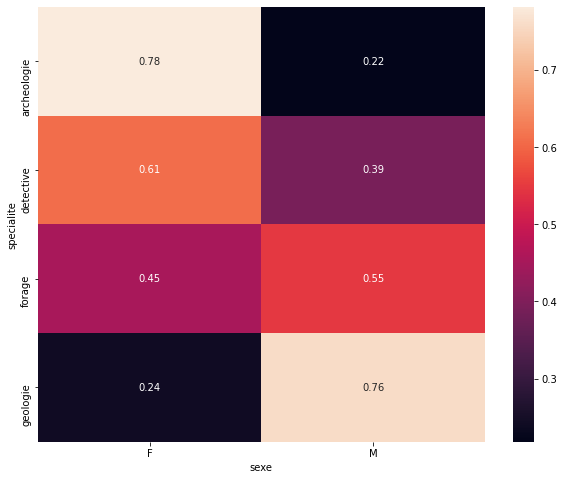

In [ ]:
x = data['specialite']
y = data['sexe']
plt.figure(figsize=(10,8)) 
contigency=pd.crosstab(x, y,normalize='index')
sns.heatmap(contigency,annot=True)
plt.show()

In [ ]:
contigency

sexe,F,M
specialite,,
archeologie,0.782127,0.217873
detective,0.608181,0.391819
forage,0.452106,0.547894
geologie,0.240574,0.759426


In [ ]:
c, p, dof, expected = chi2_contingency(contigency) 
# Print the p-value
print(p)

0.8877295847888335


Ici p=0.89, donc les variables spécialité et sexe sont indépendantes.

In [ ]:
x2 = data['cheveux']
y2 = data['salaire']
contigency2 = pd.crosstab(x2, y2,normalize='index')

c, p, dof, expected = chi2_contingency(contigency2) 
# Print the p-value
print(p)

0.9999999999820827


Ici p=0.99, donc les variables couleurs des cheveux et salaires sont indépendantes.

In [ ]:
x3 = data['exp']
y3 = data['note']
contigency3 = pd.crosstab(x3, y3,normalize='index')

c, p, dof, expected = chi2_contingency(contigency3)
# Print the p-value
print(p)

1.0


Ici p=1, donc les variables experience et note à l'examen sont indépendantes.

In [ ]:
x4 = data['embauche']
y4 = data['sexe']
contigency4 = pd.crosstab(x4, y4,normalize='index')

c, p, dof, expected = chi2_contingency(contigency4)
# Print the p-value
print(p)

1.0


## Creation de la target et des features

In [ ]:
TARGET = 'embauche'
CATEGORICALS = ['dispo', 'diplome','specialite','age','salaire']
NUMERICALS = ['note_norm']
FEATURES = CATEGORICALS + NUMERICALS

In [ ]:
# Transformation en variables binaires
data_dummies = pd.get_dummies(data[CATEGORICALS].astype('category'))
CATEGORICALS = data_dummies.columns

data[CATEGORICALS] = data_dummies[CATEGORICALS]

In [ ]:
data[CATEGORICALS].head()

,dispo_non,dispo_oui,diplome_bac,diplome_doctorat,diplome_licence,diplome_master,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,"age_(0, 30]","age_(30, 40]","age_(40, 50]","age_(50, 70]","salaire_(0, 30000]","salaire_(30000, 35000]","salaire_(35000, 40000]","salaire_(40000, 70000]"
0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
5,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0


In [ ]:
FEATURES = list(CATEGORICALS) + NUMERICALS

## 2. Machine Learning

### 1. Concevez un modèle permettant de prédire la variable embauche

Lorsque l'on sépare nos données en test et train, on s'assurer que la distribution de leurs cibles soit la même que la cible du dataset de base. Pour rappel, on avait comme distribution de la Target :
<ul> 
<li>89% de recalés 
<li>11% de personnes embauchées 
</ul>

In [ ]:
data['embauche'].value_counts(normalize=True)

0    0.885394
1    0.114606
Name: embauche, dtype: float64

<AxesSubplot:xlabel='embauche', ylabel='count'>

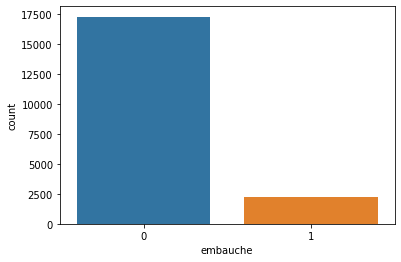

In [ ]:
sns.countplot(data['embauche'])

#### Préparation des données test et d'entraînement

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[FEATURES], data[TARGET],stratify=y, test_size=0.20, random_state=5)

In [ ]:
# Les données ont bien gardé la distribution de base grâce au 'stratify=y'
y_train.value_counts(normalize=True)

0    0.886339
1    0.113661
Name: embauche, dtype: float64

In [ ]:
X_train.head()

,dispo_non,dispo_oui,diplome_bac,diplome_doctorat,diplome_licence,diplome_master,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,"age_(0, 30]","age_(30, 40]","age_(40, 50]","age_(50, 70]","salaire_(0, 30000]","salaire_(30000, 35000]","salaire_(35000, 40000]","salaire_(40000, 70000]",note_norm
8873,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1.378594
4748,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0.301078
8451,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,-0.766460
6947,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1.285866
13675,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,-0.453652


Nous sommes en présence d'un problème de classification. On peut donc utiliser la <b>méthode des KNN (K nearest neighbors)</b> et <b> Random Forrest </b>. Nous allons ici faire une comparaison succinte des deux méthodes.

#### Méthode KNN (K Nearest Neighbours)

On commence par lancer plusieurs fois le modèle sur notre jeu de données test afin d'obtenir un bon $k$ ($k_{ideal}$, c'et-à-dire ici celui qui va optimiser l'accuracy)

In [ ]:
scores = []
k_range = list(range(1,20))
for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test,y_pred))

100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


In [ ]:
ideal_k = k_range[scores.index(max(scores))]
ideal_k

15

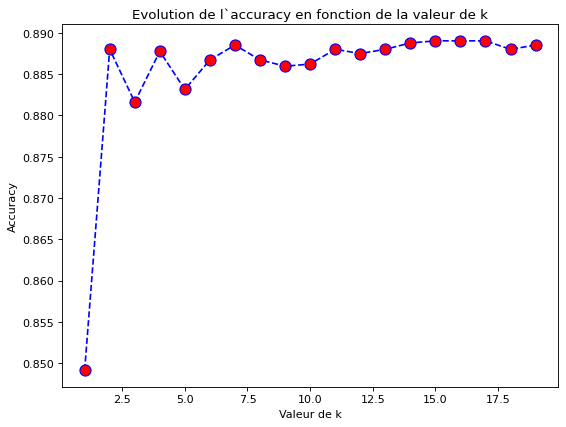

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(k_range,scores,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.xlabel('Valeur de k')
plt.ylabel('Accuracy')
plt.title('Evolution de l`accuracy en fonction de la valeur de k')
plt.show()

On peut dénoter que <b>K=15</b> peut être une valeur intéressantes/idéale pour notre modélisation, ainsi on l'implémente comme suit:

In [ ]:
model=KNeighborsClassifier(n_neighbors=ideal_k)
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=15)

In [ ]:
print('Resultats KNN avec K = '+str(ideal_k))
print(classification_report(y_test.to_list(), y_pred))

Resultats KNN avec K = 15
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3448
           1       0.70      0.10      0.18       463

    accuracy                           0.89      3911
   macro avg       0.79      0.55      0.56      3911
weighted avg       0.87      0.89      0.85      3911



#### Méthode Random Forrest

L'idée est de lancer plusieurs fois le modèle sur notre je de données test afin d'obtenir un bon la profondeur de la forêt qui va optimiser l'accuracy.

In [ ]:
scores = []
depth_range = list(range(5,30))
for k in tqdm(depth_range):
    clf = RandomForestClassifier(max_depth=k, random_state=0)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test,y_pred))

100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


In [ ]:
ideal_depth = depth_range[scores.index(max(scores))]
ideal_depth

12

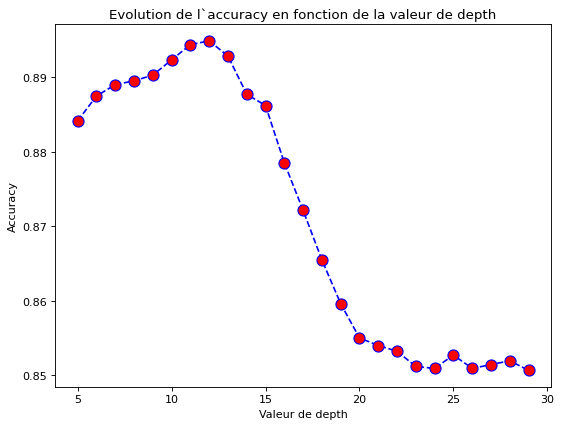

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(depth_range,scores,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.xlabel('Valeur de depth')
plt.ylabel('Accuracy')
plt.title("Evolution de l'accuracy en fonction de la valeur de depth")
plt.show()

In [ ]:
clf = RandomForestClassifier(max_depth=ideal_depth, random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print('Resultats Random Forrest avec depth = ' + str(ideal_k))
print(classification_report(y_test.to_list(), y_pred))

Resultats Random Forrest avec depth = 15
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3448
           1       0.70      0.20      0.31       463

    accuracy                           0.89      3911
   macro avg       0.80      0.59      0.63      3911
weighted avg       0.88      0.89      0.87      3911



Ici, on remarque que le modèle Random Forrest donne de meilleures métriques de performance que le modèle KNN concernant la prédiction de l'embauche.

### 2. Quelles sont les variables les plus importantes de votre modèle ? Commentez.

Quand on utilise le modèle RandomForrest, il est possible de connaître les Features les plus importants en utilisant des méthodes Embedded.

Lorsque l'on fait l'analyse une première fois, on dénote que c'est la <b>note obtenue à l'exercice de recherche d'or</b> qui influence le plus notre modèle.

In [ ]:
X = X_train
y = y_train

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=12),max_features=18)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

1 selected features
['note_norm']


Lorsque l'on fait un test en supprimant les données des notes, il nous reste finalement comme Features principaux la <b>disponibilité immédiate</b> du candidat et également la <b>spécialité de son diplôme</b>.

Ainsi comme variables les plus importantes de notre modèle, on a la note , le disponibilité immédiate et la spécialité du diplôme

Cela s'inscrit plus ou moins aisément dans le cadre d'un processus de recrutement à savoir que dans la plupart des entreprises ces variables influencent grandement la sélection. Par exemple, si on considère deux candidats:
<ul>
<li> A = Axel candidat ayant une note de 20/100 à l'exercice de recherche d'or, disponible immédiatement et ayant comme spécialité la géologie, et
<li> B = Bertrand candidat ayant une note de 60/100 à l'exercice de recherche d'or,aussi disponible immédiatement et ayant aussi comme spécialité la géologie
</ul>

On serait  même humainement tentés de se dire que toutes choses égales par ailleurs, B aurait a priori plus de chances d'être recruté que A.

### 3. Décrivez et justifiez le critère de performance utilisé

Nous avons utilisé 3 critères de performance pour l'évaluation de nos modèles :
<ul>
<li> l'<b>accuracy</b> qui est la proportion de vrais résultats sur tous les cas examinés 
<li> la <b>précision</b> qui donne la proportion de valeurs positives prédites qui le sont réellement
<li> le <b>recall</b> qui donne la proportion de Vrais Positifs qui sont bien classés
</ul>

Il est important de noter que l'accuracy est une mesure facile à comprendre et c'est principalement la raison pour laquelle nous l'avons utilisée. Cependant, le jeu de données contient un tel déséquilibre de classe (distribution ~90/10) que cette mesure n'est pas intéressante pour attester de l'effectivité du modèle.

Il convient mieux d'utiliser les valeurs comme la precision et le recall pour chacune des classes. Encore une fois, la faible proportion des données ayant $embauche = 1$ induit ici un recall raisonnablement faible.

### 4. Proposez deux à trois pistes d’amélioration de votre modèle.

Afin d'améliorer le modèle on pourrait commencer par chercher à s'imprégner d'une connaissance métier à savoir parler avec le pôle RH recrutement afin de savoir quels paramètres typiques sont bons signes pour une candidature, lesquels sont plus pénalisants etc. de manière à mieux cibler les features les plus pertinents sur lesquels travailler.

On pourrait également penser à "équilibrer" la base, c'est à dire d'essayer d'avoir - par exemple - 40% de 1 au total (au lieu de 11%) afin de mieux entraîner notre modèle. Cette partie impacte le résultat dans la mesure ou notre valeur de <b>recall</b> (proportion des Vrais Positifs bien classés) est toujours assez faible (proche des 30%)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eb7dcf26-eb0d-4e7d-b73a-acc8f40d7b73' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>